In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from six import StringIO
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [45]:
!pip install imblearn

  Using cached https://files.pythonhosted.org/packages/e5/4c/7557e1c2e791bd43878f8c82065bddc5798252084f26ef44527c02262af1/imbalanced_learn-0.4.3-py3-none-any.whl


In [2]:
from our_functions import display_acc_and_f1_score

In [3]:
df = pd.read_csv('data/cleaned_data.csv')

In [4]:
df.head()

,sample_pk,commod,commtype,lab,pestcode,lod,annotate,avg_detect,extract,determin,concentration
0,239,AJ,RE,WA1,083,0.005,Q,O,805,35,80000.0
1,1183,BR,FR,FL1,AFU,0.010,V,O,805,52,110000.0
2,1196,BR,FR,FL1,AFU,0.010,V,O,805,52,130000.0
3,1230,BR,FR,FL1,144,0.005,V,O,805,35,350000.0
4,1269,BR,FR,FL1,180,0.010,V,O,805,52,260000.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4887 entries, 0 to 4886
Data columns (total 11 columns):
sample_pk        4887 non-null int64
commod           4887 non-null object
commtype         4887 non-null object
lab              4887 non-null object
pestcode         4887 non-null object
lod              4887 non-null float64
annotate         4887 non-null object
avg_detect       4887 non-null object
extract          4887 non-null int64
determin         4887 non-null int64
concentration    4887 non-null float64
dtypes: float64(2), int64(3), object(6)
memory usage: 420.1+ KB


## Split data

In [6]:
X = df.drop(['annotate'], axis=1)
y = df.annotate

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=20)

## One-hot-encode data. Note that splitting the date before encoding resulted in too many different categories match dimensions of data to train with test, so we had to onehotencode first.

In [8]:
categoricals = ['commod', 'commtype', 'lab', 'pestcode', 'avg_detect']

In [9]:
encoder= OneHotEncoder(categories = 'auto', drop='first')
encoder = encoder.fit(X[categoricals])

In [10]:
encoder.categories_

[array(['AJ', 'BR', 'BU', 'CE', 'CF', 'CR', 'GB', 'GJ', 'IA', 'MU', 'NE',
        'PC', 'PU', 'RS', 'RZ', 'SS', 'WG', 'WR', 'WS', 'WU'], dtype=object),
 array(['FR', 'FZ', 'PU', 'RE'], dtype=object),
 array(['CA1', 'FL1', 'MI1', 'MN1', 'MT1', 'NY1', 'OH1', 'TX1', 'WA1'],
       dtype=object),
 array(['014', '024', '026', '028', '032', '034', '042', '052', '070',
        '083', '114', '125', '129', '134', '143', '144', '149', '151',
        '157', '159', '160', '165', '170', '171', '172', '173', '178',
        '180', '200', '204', '222', '223', '230', '237', '249', '255',
        '264', '283', '305', '318', '333', '351', '382', '387', '512',
        '537', '539', '540', '597', '604', '607', '612', '624', '626',
        '633', '651', '666', '679', '699', '701', '714', '717', '718',
        '720', '731', '758', '780', '781', '784', '785', '808', '900',
        '901', '902', '906', '907', '908', '910', '911', '930', '942',
        '945', '948', '956', '964', '967', 'A25', 'A30', 'A42', 'A5

In [11]:
ohe = pd.DataFrame(encoder.transform(X[categoricals]).toarray(), 
                   columns=encoder.get_feature_names(categoricals))
ohe.head()

,commod_BR,commod_BU,commod_CE,commod_CF,commod_CR,commod_GB,commod_GJ,commod_IA,commod_MU,commod_NE,...,pestcode_B64,pestcode_B72,pestcode_B75,pestcode_B77,pestcode_B79,pestcode_B80,pestcode_B82,pestcode_B84,pestcode_B85,avg_detect_R
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4887 entries, 0 to 4886
Columns: 179 entries, commod_BR to avg_detect_R
dtypes: float64(179)
memory usage: 6.7 MB


In [13]:
X = X.join(ohe).drop(categoricals, axis=1)
X.head()

,sample_pk,lod,extract,determin,concentration,commod_BR,commod_BU,commod_CE,commod_CF,commod_CR,...,pestcode_B64,pestcode_B72,pestcode_B75,pestcode_B77,pestcode_B79,pestcode_B80,pestcode_B82,pestcode_B84,pestcode_B85,avg_detect_R
0,239,0.005,805,35,80000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1183,0.010,805,52,110000.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1196,0.010,805,52,130000.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1230,0.005,805,35,350000.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1269,0.010,805,52,260000.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Split encoded data

In [29]:
enc_X_train, enc_X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=20)

## Nearest neighbors model

In [30]:
knc = KNeighborsClassifier()
knc.fit(enc_X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [31]:
y_train.value_counts()

Q     3624
V      149
QV     117
X       19
Name: annotate, dtype: int64

In [32]:
k_preds = knc.predict(enc_X_test)

In [33]:
y_test.value_counts()

Q     909
V      37
QV     28
X       4
Name: annotate, dtype: int64

In [39]:
np.unique(k_preds, return_counts=True)

(array(['Q', 'QV', 'V', 'X'], dtype=object), array([951,   7,  17,   3]))

In [35]:
knc.score(enc_X_test, y_test)

0.9519427402862985

## Logistic regression model

In [21]:
import statsmodels.api as sm

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
mul_r = LogisticRegression(multi_class='multinomial', solver='lbfgs')
mul_r.fit(enc_X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
mul_r.score(enc_X_test, y_test)

0.9294478527607362

In [25]:
mul_r.score(enc_X_train, y_train)

0.9270913277052955

It looks like our target variable has an abnormal distribution.

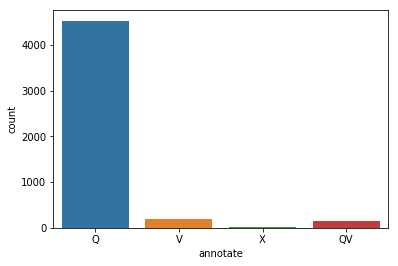

In [42]:
sns.countplot(x=df['annotate'], data=df)

We'll resample to improve target representation.

In [49]:
smote = SMOTE('not majority')
X_smote, y_smote = smote.fit_resample(enc_X_train, y_train)

In [51]:
np.unique(y_smote, return_counts=True)

(array(['Q', 'QV', 'V', 'X'], dtype=object), array([3624, 3624, 3624, 3624]))

There's an even distribution, so now we'll train our models on the SMOTE data.

In [66]:
knc = KNeighborsClassifier()
knc.fit(X_smote, y_smote)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [67]:
knc.score(enc_X_test, y_test)

0.8732106339468303

0.873 is still quite high. 

In [59]:
mul_r = LogisticRegression(multi_class='multinomial', solver='lbfgs')
mul_r.fit(X_smote, y_smote)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
mul_r.score(X_smote, y_smote)

0.25